In [30]:
import pandas as pd
import numpy as np
import tensorflow as tf
import sys
from PIL import Image
from matplotlib import pyplot as plt
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Convolution2D, Dropout, Input, GlobalAveragePooling2D, MaxPooling2D, Flatten, Dense# Sequential model for building a linear stack of layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import Xception

In [31]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [32]:
!unzip drive/My\ Drive/images.zip

In [33]:
sys.path.append('/content/drive/MyDrive/face2face/functions')

In [34]:
from create_dataframe import create_df

In [35]:
train_meta = create_df('train')
valid_meta = create_df('valid')
test_meta = create_df('test')

In [36]:
# Specify the base path where your image data is stored
base_path = '/content/real_vs_fake/real-vs-fake/'


# Create an ImageDataGenerator for image preprocessing and augmentation
image_gen = ImageDataGenerator(rescale=1./255.,
                               horizontal_flip=True)


In [37]:
Xception_train = image_gen.flow_from_directory(
    base_path + 'train/',
    target_size=(224, 224),
    batch_size=128,
    class_mode='binary'
)
Xception_valid = image_gen.flow_from_directory(
    base_path + 'valid/',
    target_size=(224, 224),
    batch_size=128,
    class_mode='binary'
)
Xception_test = image_gen.flow_from_directory(
    base_path + 'test/',
    target_size=(224, 224),
    batch_size=128,
    class_mode='binary',
    shuffle=False
)

Found 100000 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.


In [38]:
base_model = Xception(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

In [39]:
for layer in base_model.layers:
  layer.trainable=False

In [40]:
model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 7, 7, 2048)        20861480  
                                                                 
 global_average_pooling2d_2  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_6 (Dense)             (None, 256)               524544    
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 dense_7 (Dense)             (None, 1)                 257       
                                                                 
Total params: 21386281 (81.58 MB)
Trainable params: 524801 (2.00 MB)
Non-trainable params: 20861480 (79.58 MB)
_________

In [41]:
learning_rate = 0.0001

In [42]:
model.compile(optimizer=Adam(learning_rate = learning_rate), loss='binary_crossentropy', metrics=['accuracy'])

In [43]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [44]:
history = model.fit(Xception_train, epochs=100, validation_data=(Xception_valid), callbacks=[early_stopping])

Epoch 1/100
782/782 [==============================] - 505s 641ms/step - loss: 0.5480 - accuracy: 0.7196 - val_loss: 0.4963 - val_accuracy: 0.7639
Epoch 2/100
782/782 [==============================] - 499s 639ms/step - loss: 0.4896 - accuracy: 0.7642 - val_loss: 0.4661 - val_accuracy: 0.7828
Epoch 3/100
782/782 [==============================] - 500s 639ms/step - loss: 0.4647 - accuracy: 0.7809 - val_loss: 0.4462 - val_accuracy: 0.7961
Epoch 4/100
782/782 [==============================] - 499s 638ms/step - loss: 0.4467 - accuracy: 0.7913 - val_loss: 0.4349 - val_accuracy: 0.8005
Epoch 5/100
782/782 [==============================] - 499s 638ms/step - loss: 0.4339 - accuracy: 0.7991 - val_loss: 0.4229 - val_accuracy: 0.8082
Epoch 6/100
782/782 [==============================] - 499s 639ms/step - loss: 0.4222 - accuracy: 0.8067 - val_loss: 0.4181 - val_accuracy: 0.8089
Epoch 7/100
782/782 [==============================] - 499s 638ms/step - loss: 0.4113 - accuracy: 0.8116 - val_loss: 0

In [45]:
import pickle
with open('/content/drive/MyDrive/face2face/models/Xception_history.pkl', 'wb') as f:
  pickle.dump(history.history, f)
with open('/content/drive/MyDrive/face2face/models/Xception.pkl', 'wb') as f:
    pickle.dump(model, f)

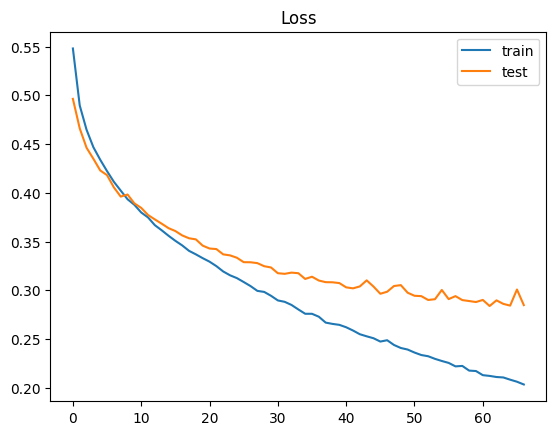

In [46]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.title('Loss')
plt.show()

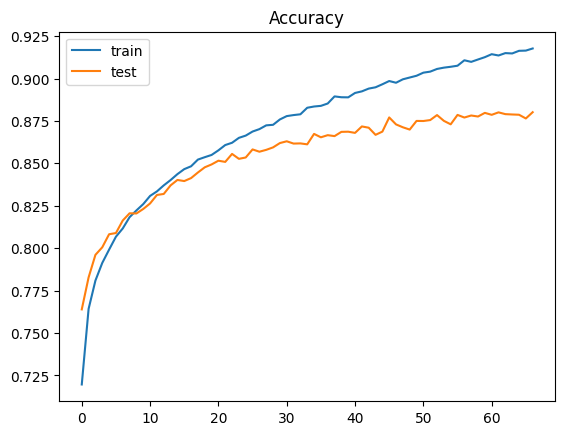

In [47]:
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.title('Accuracy')
plt.show()

In [54]:
y_true = Xception_test.classes
y_pred = model.predict(Xception_test)

157/157 [==============================] - 83s 532ms/step


In [65]:
y_pred_labels = (y_pred > 0.5).astype(int)

In [67]:
from sklearn.metrics import confusion_matrix, classification_report

In [68]:
confusion_matrix(y_true, y_pred_labels)

array([[8824, 1176],
       [1239, 8761]])

In [69]:
Xception_metrics = classification_report(y_true, y_pred_labels)

In [70]:
print(Xception_metrics)

              precision    recall  f1-score   support

           0       0.88      0.88      0.88     10000
           1       0.88      0.88      0.88     10000

    accuracy                           0.88     20000
   macro avg       0.88      0.88      0.88     20000
weighted avg       0.88      0.88      0.88     20000

